In [1]:
## This version excludes CONTINUOUS Variables and the RFD variables AND _wHICH VARIABLES 3/27/2024 and con_max_consultorder_time/day and drg name

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection
from feature_engine.encoding import OneHotEncoder
from feature_engine.selection import DropFeatures, DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection
from feature_engine.imputation import AddMissingIndicator
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import MinMaxScaler
from feature_engine.discretisation import DecisionTreeDiscretiser
from sklearn.model_selection import GroupShuffleSplit

from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import RareLabelEncoder
from sklearn.impute import SimpleImputer

#pip install xgboost==0.90
import xgboost as xgb
import plotly.express as px
import shap

#https://github.com/liannewriting/YouTube-videos-public/blob/main/xgboost-python-tutorial-example/xgboost_python.ipynb
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
#hyperparameter values
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, classification_report, precision_recall_curve
from sklearn.calibration import calibration_curve

import warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_1507204/1918152630.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
df_all = pd.read_csv('/gpfs/milgram/project/rtaylor/imc33/data/clean/master_los.csv', index_col=[0])

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
df_all.head()

,admissiondate,dischargedate,pat_mrn_id,viz_primary_payer_name,viz_disp_collapsed,viz_age,viz_ethnicity,viz_race,viz_race_collapsed,viz_language,viz_insurance,viz_service_collapsed,viz_ynhhs_sg2_service,viz_observed_mortality_yn,viz_drg,viz_admission_day,viz_discharged_day,viz_outcome_prolonged_los_yn,thro_door_to_admit_order_hrs,thro_admit_order_to_first_bed_hrs,thro_last_bed_to_ed_dept_hrs,thro_admit_order_to_ed_dept_hrs,thro_boarding_yn,thro_ed_arrival_time,thro_ed_arrival_day,thro_admit_or_obs_order_time,thro_admit_or_obs_order_day,thro_first_bed_assigned_time,thro_first_bed_assigned_day,thro_last_bed_assigned_time,thro_last_bed_assigned_day,thro_ed_departure_time,thro_ed_departure_day,summary_consult_count_all,summary_consult_count_unique_services,summary_pt_consult_order_yn,summary_pt_consult_order_time,summary_pt_consult_order_day,summary_sw_consult_order_yn,summary_sw_consult_order_time,summary_sw_consult_order_day,summary_first_edd_time,summary_first_edd_day,summary_first_edd_doc_time,summary_first_edd_doc_day,summary_first_edd_to_discharge_hrs,summary_first_edd_doc_to_discharge_hrs,summary_last_edd_time,summary_last_edd_day,summary_last_edd_doc_time,summary_last_edd_doc_day,summary_last_edd_to_discharge_hrs,summary_last_edd_doc_to_discharge_hrs,summary_first_rfd_status,summary_first_rfd_time,summary_first_rfd_day,summary_first_rfd_to_discharge_hrs,summary_last_rfd_status,summary_last_rfd_time,summary_last_rfd_day,summary_last_rfd_to_discharge_hrs,summary_total_hrs_nmr,summary_total_hrs_mrwb,summary_total_hrs_mrnb,rfd_first_nmr_start_day,rfd_first_nmr_start_time,rfd_first_mrnb_start_day,rfd_first_mrnb_start_time,rfd_first_mrwb_start_day,rfd_first_mrwb_start_time,rfd_first_nmr_to_discharge_hrs,rfd_first_mrnb_to_discharge_hrs,rfd_first_mrwb_to_discharge_hrs,rfd_last_nmr_effective_end_day,rfd_last_nmr_effective_end_time,rfd_last_mrnb_effective_end_day,rfd_last_mrnb_effective_end_time,rfd_last_mrwb_effective_end_day,rfd_last_mrwb_effective_end_time,rfd_last_nmr_to_discharge_hrs,rfd_last_mrnb_to_discharge_hrs,rfd_last_mrwb_to_discharge_hrs,con_max_consult_order_to_sign_any_hrs,con_avg_consult_order_to_sign_any_hrs,con_max_consult_note_to_sign_any_hrs,con_avg_consult_note_to_sign_any_hrs,con_signer_ym_provider_count,con_signer_nemg_provider_count,con_signer_community_provider_count,con_max_consult_order_to_sign_colon_and_rectal_hrs,con_max_consult_order_to_sign_diabetes_hrs,con_max_consult_order_to_sign_hematology_hrs,con_max_consult_order_to_sign_infectious_disease_hrs,con_max_consult_order_to_sign_lab_medicine_hrs,con_max_consult_order_to_sign_nephrology_hrs,con_max_consult_order_to_sign_oncology_hrs,con_max_consult_order_to_sign_picc_hrs,con_max_consult_order_to_sign_palliative_hrs,con_max_consult_order_to_sign_pulmonology_hrs,con_max_consult_order_to_sign_radiation_oncology_hrs,con_max_consult_order_to_sign_radiology_hrs,con_max_consult_order_to_sign_urology_hrs,con_max_consult_order_to_sign_cardiology_hrs,con_max_consult_order_to_sign_gastroenterology_hrs,con_max_consult_order_to_sign_hepatology_hrs,con_max_consult_order_to_sign_other_hrs,con_max_consult_order_to_sign_pharmacy_hrs,con_max_consult_order_to_sign_plastic_surgery_hrs,con_max_consult_order_to_sign_surgery_hrs,con_max_consult_order_to_sign_vascular_surgery_hrs,con_max_consult_order_to_sign_neurology_hrs,con_max_consult_order_to_sign_hospitalist_service_hrs,con_max_consult_order_to_sign_psychiatry_hrs,con_max_consult_order_to_sign_internal_medicine_hrs,con_max_consult_order_to_sign_neuro_oncology_hrs,con_max_consult_order_to_sign_neurosurgery_hrs,con_max_consult_order_to_sign_ophthalmology_hrs,con_max_consult_order_to_sign_orthopedics_hrs,con_max_consult_order_to_sign_physical_medicine_and_rehabilitation_hrs,con_max_consult_order_to_sign_podiatry_hrs,con_max_consult_order_to_sign_dermatology_hrs,con_max_consult_order_to_sign_geriatrics_hrs,con_max_consult_order_to_sign_addiction_medicine_hrs,con_max_consult_order_to_sign_otolaryngology_ent_hrs,con_max_consult

In [6]:
df_all.shape

(13205, 337)

In [7]:
df_all["viz_disp_collapsed"].value_counts()

viz_disp_collapsed
Other    8346
Home     4859
Name: count, dtype: int64

In [8]:
df_all["thro_boarding_yn"].value_counts()

thro_boarding_yn
1.0    6895
0.0    5585
Name: count, dtype: int64

In [9]:
df_all["viz_quartile"].value_counts()

viz_quartile
middle    5510
fourth    4035
first     3660
Name: count, dtype: int64

In [10]:
#Filter for home patients
#df_filt = df_all.copy()
#df_filt = df_all[df_all["viz_disp_collapsed"] == "Home"].copy()
df_filt = df_all[df_all["viz_quartile"] == "fourth"].copy()

In [11]:
#df_filt.shape

In [12]:
# aitc_features.xlsx includes all the feature names and corresponding types
features_los = pd.read_excel('/gpfs/milgram/project/rtaylor/imc33/data/clean/features_los.xlsx')

# Features that are divided into 5 types to conduct data preprocessing
# 1. drop: features that need to be dropped
drop_list = features_los[features_los['type'] == 'drop']['col_name'].tolist()

# 2. category: features that are already categorical and need to be OneHotEncoding (add missing value indicator, impute missing by adding 'missing' category)
category_list = features_los[features_los['type'] == 'category']['col_name'].tolist()

# 3. binary: features that are binary and need to be converted to categorical (add missing value indicator / prefer: fill missing with 0)
binary_list = features_los[features_los['type'] == 'binary']['col_name'].tolist()

# 4. continuous: features that are continous/numerical variables, need outlier handling and normalization (add missing value indicator, fill missing with median)
continuous_list = features_los[features_los['type'] == 'continuous']['col_name'].tolist()

# 5. discrete: features that are discrete/numerical variables, need to be discretized (fill missing with 0)
discrete_list = features_los[features_los['type'] == 'discrete']['col_name'].tolist()

In [13]:
# Identify variables with infinite values
#variables_with_inf = df_filt.columns[df_filt.isin([np.inf, -np.inf]).any()]

# Handle infinite values (e.g., replace with NaN)
#df_filt[variables_with_inf] = df_filt[variables_with_inf].replace([np.inf, -np.inf], np.nan)

In [14]:
# Split into X, y
X = df_filt.drop(['viz_outcome_prolonged_los_yn'], axis=1)
y = df_filt['viz_outcome_prolonged_los_yn']

In [15]:
# Convert variables to categorical
X[binary_list] = X[binary_list].astype('category')
X[category_list] = X[category_list].astype('category')

In [16]:
# Drop features that have >= 99% missing values And features in drop list
missing_pct = X.isnull().mean() * 100
cols_to_drop = missing_pct[missing_pct >= 99].index.tolist()
#final_drop_list = list(set(drop_list + cols_to_drop))
#X_1b = X_1b.drop(columns=final_drop_list)
#X_1b = X_1b.reset_index(drop=True)
#y_1b = y_1b.reset_index(drop=True)

In [17]:
pd.set_option('display.max_rows', 400)

In [18]:
missing_pct.reset_index().sort_values(0, ascending=False).head()

,index,0
247,con_avg_consult_note_to_sign_sw_hrs,100.0
127,con_max_consult_order_to_sign_sw_hrs,100.0
135,con_max_consult_note_to_sign_picc_hrs,100.0
215,con_avg_consult_note_to_sign_picc_hrs,100.0
201,con_avg_consult_order_to_sign_addiction_medici...,100.0


In [19]:
continuous_list.remove("viz_age")

In [20]:
# We do NOT want to drop these
#cols_to_drop
#only these
drop_list

['rfd_first_nmr_start_day',
 'rfd_first_nmr_start_time',
 'rfd_first_mrnb_start_day',
 'rfd_first_mrnb_start_time',
 'rfd_first_mrwb_start_day',
 'rfd_first_mrwb_start_time',
 'rfd_last_nmr_effective_end_day',
 'rfd_last_nmr_effective_end_time',
 'rfd_last_mrnb_effective_end_day',
 'rfd_last_mrnb_effective_end_time',
 'rfd_last_mrwb_effective_end_day',
 'rfd_last_mrwb_effective_end_time',
 'con_max_consult_order_to_sign_which',
 'con_max_consult_order_time',
 'con_max_consult_order_day',
 'con_max_date_note_signed_time1',
 'con_max_date_note_signed_day1',
 'con_max_consult_note_to_sign_which',
 'admissiondate',
 'ed_arrival_time',
 'ed_arrival_hour',
 'ed_arrival_date',
 'dischargedate',
 'viz_quartile']

In [21]:
X = X.drop(columns=drop_list+continuous_list)
X = X.reset_index()
y = y.reset_index()

In [22]:
# Split the data by group shuffle split on 'PAT_MRN_ID' into train set and validation set
gss = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=42)

train_ix, val_ix = next(gss.split(X, y, groups=X['pat_mrn_id']))

X_train = X.loc[train_ix]
y_train = y.loc[train_ix]

X_val = X.loc[val_ix]
y_val = y.loc[val_ix]

# Drop 'PAT_MRN_ID' and set 'PAT_ENC_CSN_ID' as index
X_train = X_train.drop(['pat_mrn_id'], axis=1).set_index('pat_enc_csn_id')
X_val = X_val.drop(['pat_mrn_id'], axis=1).set_index('pat_enc_csn_id')

### Feature Processing

In [23]:

# Update feature preprocessing pipeline
feature_preprocess_pipeline = Pipeline(steps=[

    # Missing value indicator for categoricals and continuous variables
    #('missing_indicator', AddMissingIndicator(variables=category_list + continuous_list)),

    # Missing value imputation
    # Impute missing values with 0 for discrete variables
    ('arbitrary_number_imputer', ArbitraryNumberImputer(arbitrary_number=0, variables=discrete_list)),

  
    # Impute missing values with adding 'missing' category for categorical variables 
   ('categorical_imputer', CategoricalImputer(variables=category_list)),

    # Impute missing values with 0 for binary variables 
    ('binary_imputer', CategoricalImputer(fill_value='0', variables=binary_list)),

    
    # Rare encoding for categorical variables
    ('rare_label_encoder', RareLabelEncoder(tol=0.01, n_categories=5, max_n_categories=10, variables=category_list)),

    # OneHotEncoding for categoricals
    ('one_hot_category', OneHotEncoder(variables=category_list)),

    # Outlier handling & normalization for continous variables
   #('outlier_handling', Winsorizer(capping_method='gaussian', tail='right', fold=3, variables=continuous_list)),
    #todo: 

  # ('normalize', SklearnTransformerWrapper(MinMaxScaler(feature_range=(0, 1)), variables=continuous_list)),

    # discretize for discrete variables
   #('discretize', DecisionTreeDiscretiser(cv=3, scoring='roc_auc', regression=False, random_state=42, variables=discrete_list))
    #todo:
    
])  # Apply the pipeline

In [24]:
# Apply the pipeline
X_train_preprocessed = feature_preprocess_pipeline.fit_transform(X_train, y_train)
X_val_preprocessed = feature_preprocess_pipeline.transform(X_val)

In [25]:
X_train_preprocessed.shape

(3252, 292)

In [26]:
X_train_preprocessed.to_csv('/gpfs/milgram/project/rtaylor/imc33/data/pipeline/los_train_preprocessed_q4_patients_cat_only.csv')
X_val_preprocessed.to_csv('/gpfs/milgram/project/rtaylor/imc33/data/pipeline/los_val_preprocessed_q4_patients_cat_only.csv')

### Feature Selection

In [27]:
# 1st Feature Selection pipeline
feature_selection_pipeline = Pipeline(steps=[

        ('drop_constant', DropConstantFeatures(tol=0.99)),

        ('drop_duplicates', DropDuplicateFeatures()),

        ('correlated_features', SmartCorrelatedSelection(
        method='pearson',
        threshold=0.9,
        selection_method='model_performance',
        estimator=xgb.XGBClassifier(random_state=0)
        ))
])

In [28]:
# Apply the pipeline
X_train_selected = feature_selection_pipeline.fit_transform(X_train_preprocessed, y_train['viz_outcome_prolonged_los_yn'])
X_val_selected = feature_selection_pipeline.transform(X_val_preprocessed)

In [29]:
X_train_selected.to_csv('/gpfs/milgram/project/rtaylor/imc33/data/pipeline/los_train_initial_selected_q4_patients_cat_only.csv')
X_val_selected.to_csv('/gpfs/milgram/project/rtaylor/imc33/data/pipeline/los_val_initial_selected_q4_patients_cat_only.csv')

In [30]:
X_train_preprocessed.shape

(3252, 292)

In [31]:
X_train_selected.shape

(3252, 217)

In [32]:
# Read files
#X_train_selected = pd.read_csv('/gpfs/milgram/project/rtaylor/imc33/data/pipeline/los_train_initial_selected_q4_patients_cat_only.csv')
#X_val_selected = pd.read_csv('/gpfs/milgram/project/rtaylor/imc33/data/pipeline/los_val_initial_selected_q4_patients_cat_only.csv')

In [33]:
#train_selected = X_train_selected.merge(y_train, on='pat_enc_csn_id', how='left')
#val_selected = X_val_selected.merge(y_val, on='pat_enc_csn_id', how='left')

In [34]:
#train_selected = train_selected.set_index('pat_enc_csn_id')
#val_selected = val_selected.set_index('pat_enc_csn_id')

In [35]:
# Top 20 features - training set
#get_best_features(num_feats = 20, df = train_selected, df_name = 'train', target = 'viz_outcome_prolonged_los_yn')

In [36]:
y_train['viz_outcome_prolonged_los_yn'].sum()/y_train.shape[0]

0.8087330873308733

In [37]:
estimators = [
    ('encoder', TargetEncoder()),
    ('clf', XGBClassifier(random_state=8, verbosity=1))
]

tuning_pipeline = Pipeline(steps=estimators)

In [38]:
search_space = {
    'clf__max_depth': Integer(2,8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}

model_xgb = BayesSearchCV(tuning_pipeline, search_space, cv=3, n_iter=10, scoring='roc_auc', random_state=8) 

In [39]:
#y_train = y_train.set_index('pat_enc_csn_id')

In [40]:
y_train = y_train.set_index('pat_enc_csn_id')

In [41]:
#X_train_selected = X_train_selected.set_index('pat_enc_csn_id')

In [42]:
model_xgb.fit(X_train_selected,  y_train)

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('encoder', TargetEncoder()),
                                        ('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       gamma=None,
                                                       grow_policy=None,
                                                       importance_type=N...
                             'clf__learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'clf__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [43]:
model_xgb.best_estimator_

Pipeline(steps=[('encoder',
                 TargetEncoder(cols=['thro_boarding_yn',
                                     'summary_pt_consult_order_yn',
                                     'con_max_consult_order_to_sign_is_signer_ym_provider_yn',
                                     'con_max_consult_order_to_sign_is_signer_nemg_provider_yn',
                                     'con_max_consult_order_to_sign_is_signer_community_provider_yn',
                                     'con_max_consult_note_to_sign_is_signer_ym_provider_yn',
                                     'con_max_consult_n...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.006917774244564682, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=4,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=8, ...))])

In [44]:
model_xgb.best_score_

0.7383758498147585

In [45]:
y_val = y_val.set_index('pat_enc_csn_id')

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Confusion Matrix

-- Of 5831 people who did not have a prolonged LOS, 5831 (86%) were correctly classified.
-- Of 4724 people who did have prolonged LOS, 3918 (83%) were correctly classified

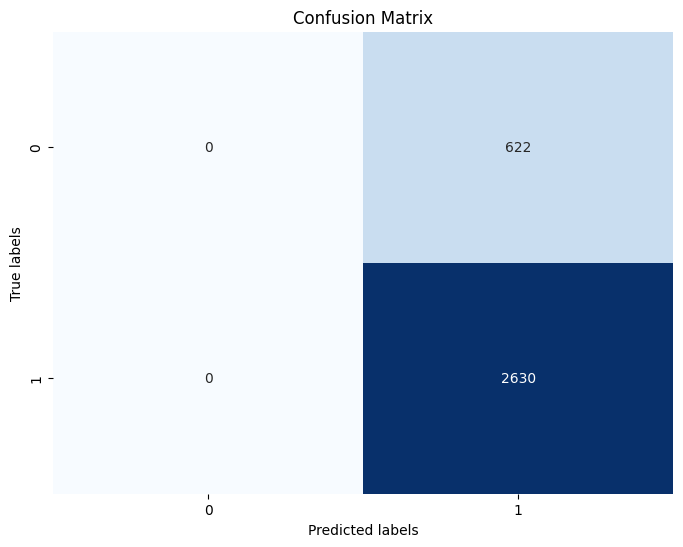

In [47]:
# Generate confusion matrix
cm = confusion_matrix(y_train, model_xgb.predict(X_train_selected))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [48]:
from sklearn import metrics

def buildROC(target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.gcf().savefig('roc.png')

In [49]:
test_preds = model_xgb.predict(X_val_selected)
target_test = y_val['viz_outcome_prolonged_los_yn']

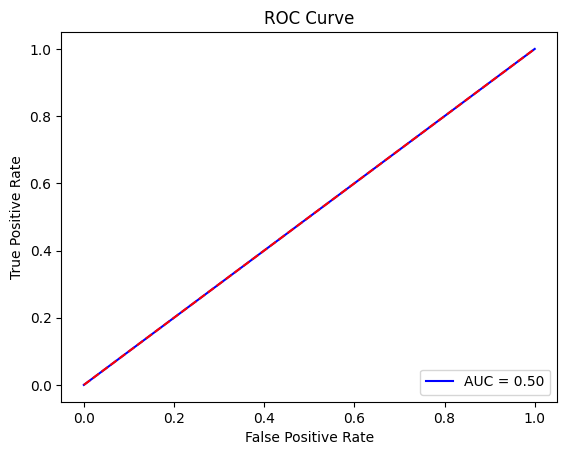

In [50]:
buildROC(target_test, test_preds)

In [51]:
def buildPR(target_test,test_preds):
    precision, recall, _ = metrics.precision_recall_curve(target_test, test_preds)
    pr_auc = metrics.auc(recall, precision)
    plt.title('PR Curve')
    plt.plot(recall, precision, label=f'PR-AUC = {pr_auc:.2f})')
    plt.legend(loc = 'lower right')
    plt.xlabel('Recall')
    plt.ylabel('Precision')

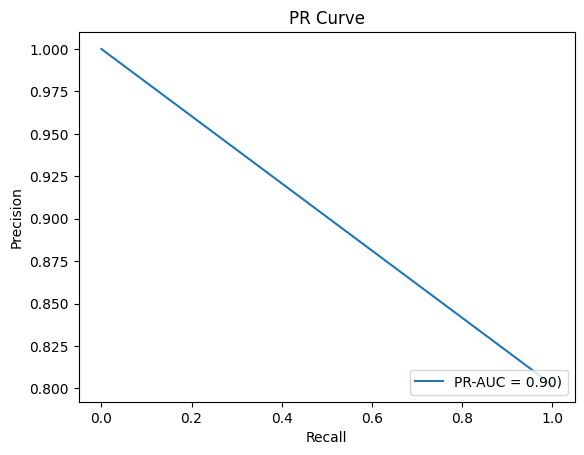

In [52]:
buildPR(target_test, test_preds)

In [53]:
def buildCC(target_test,test_preds):
      prob_true, prob_pred = calibration_curve(target_test, test_preds, n_bins=10)
      plt.plot(prob_pred, prob_true)
      plt.xlabel('Mean Predicted Probability')
      plt.ylabel('Fraction of Positives')

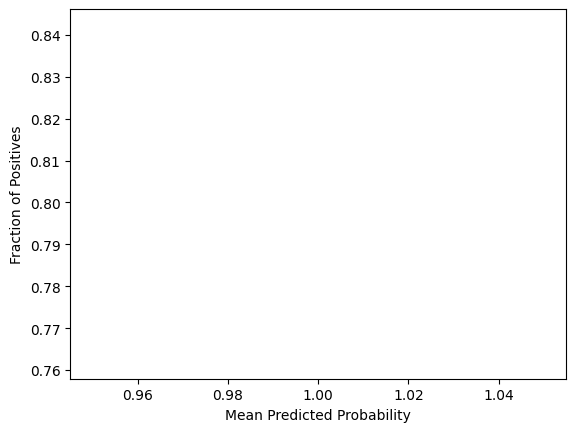

In [54]:
buildCC(target_test, test_preds)

In [55]:
#model_xgb.predict_proba(X_val)

In [56]:
model_xgb.best_estimator_.steps

[('encoder',
  TargetEncoder(cols=['thro_boarding_yn', 'summary_pt_consult_order_yn',
                      'con_max_consult_order_to_sign_is_signer_ym_provider_yn',
                      'con_max_consult_order_to_sign_is_signer_nemg_provider_yn',
                      'con_max_consult_order_to_sign_is_signer_community_provider_yn',
                      'con_max_consult_note_to_sign_is_signer_ym_provider_yn',
                      'con_max_consult_note_to_sign_is_signer_nemg_provider_yn',
                      'con_max_consult_note_to_sign_is_signer_community_provider_yn',
                      'icu_any_icu_yn'])),
 ('clf',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=0.7160044460033754,
                colsample_bynode=0.5634842539270097,
                colsample_bytree=0.8894150401192538, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=0

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

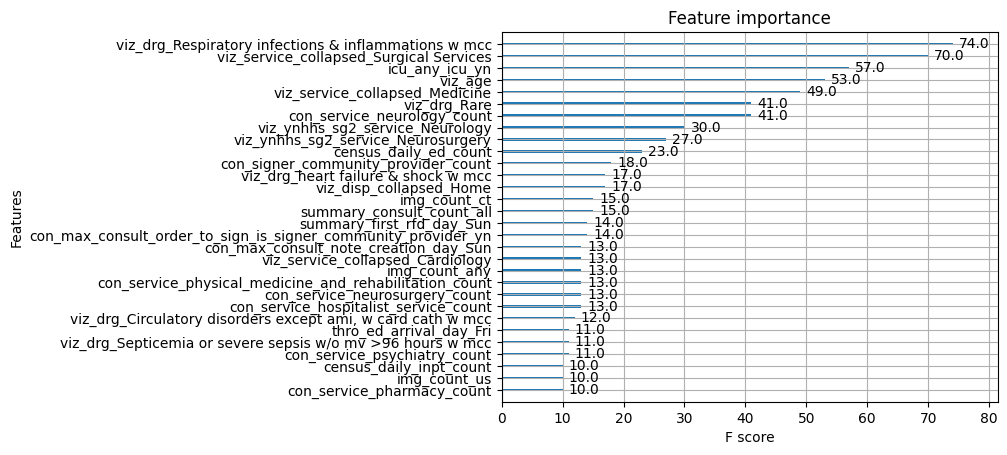

In [57]:
#https://www.youtube.com/watch?v=aLOQD66Sj0g&ab_channel=LianneandJustin
from xgboost import plot_importance

xgboost_step = model_xgb.best_estimator_.steps[1]
xgboost_model = xgboost_step[1]
plot_importance(xgboost_model, max_num_features=30)

In [58]:
xgboost_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.7160044460033754,
              colsample_bynode=0.5634842539270097,
              colsample_bytree=0.8894150401192538, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.12840880628708476,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.006917774244564682,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=8, ...)

In [59]:
X_train_selected = pd.read_csv('/gpfs/milgram/project/rtaylor/imc33/data/pipeline/los_train_initial_selected_q4_patients_cat_only.csv', index_col=[0])

In [60]:
X_val_selected = pd.read_csv('/gpfs/milgram/project/rtaylor/imc33/data/pipeline/los_val_initial_selected_q4_patients_cat_only.csv', index_col=[0])

In [61]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=None, seed=42)
clf_xgb.fit(X_train_selected, 
            y_train['viz_outcome_prolonged_los_yn'], 
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_val_selected, y_val['viz_outcome_prolonged_los_yn'])])

[0]	validation_0-aucpr:0.85497
[1]	validation_0-aucpr:0.87055
[2]	validation_0-aucpr:0.89521
[3]	validation_0-aucpr:0.90578
[4]	validation_0-aucpr:0.90390
[5]	validation_0-aucpr:0.90152
[6]	validation_0-aucpr:0.90781
[7]	validation_0-aucpr:0.90677
[8]	validation_0-aucpr:0.90594
[9]	validation_0-aucpr:0.90928
[10]	validation_0-aucpr:0.90946
[11]	validation_0-aucpr:0.90735
[12]	validation_0-aucpr:0.90790
[13]	validation_0-aucpr:0.90676
[14]	validation_0-aucpr:0.90813
[15]	validation_0-aucpr:0.90822
[16]	validation_0-aucpr:0.90721
[17]	validation_0-aucpr:0.90574
[18]	validation_0-aucpr:0.90781
[19]	validation_0-aucpr:0.90551


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=None, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [62]:
explainer = shap.Explainer(clf_xgb)
shap_values = explainer(X_val_selected)

In [63]:
#1 shap value for each feature
np.shape(shap_values.values)

(783, 217)

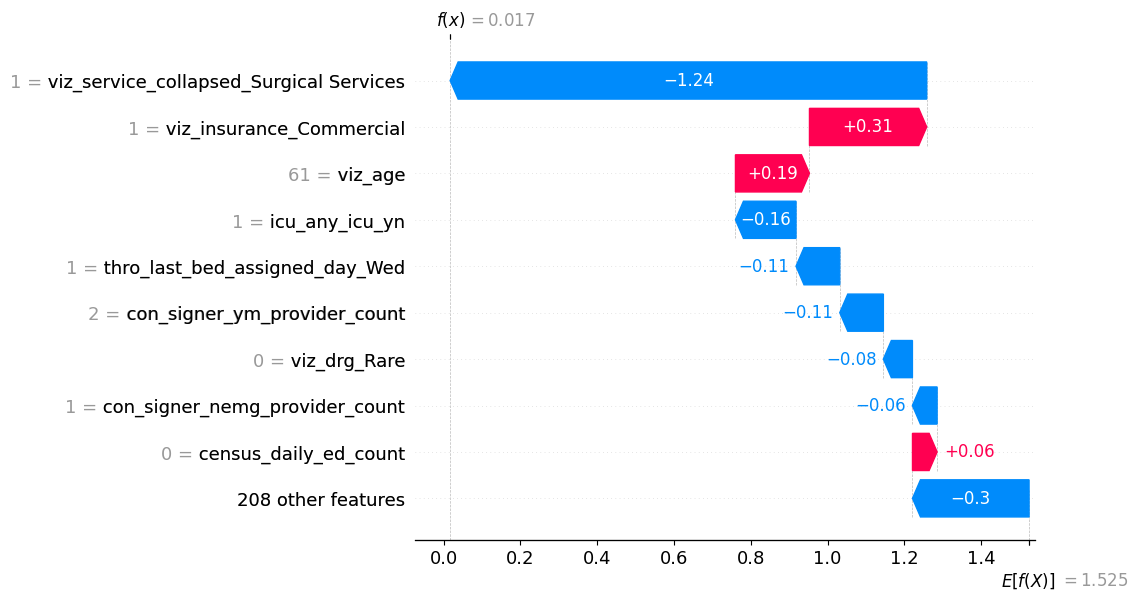

In [64]:
#This is for a single prediction
shap.plots.waterfall(shap_values[0])

In [65]:
shap.initjs(),
shap.plots.force(shap_values[0])

In [66]:
shap.plots.force(shap_values[0:100])

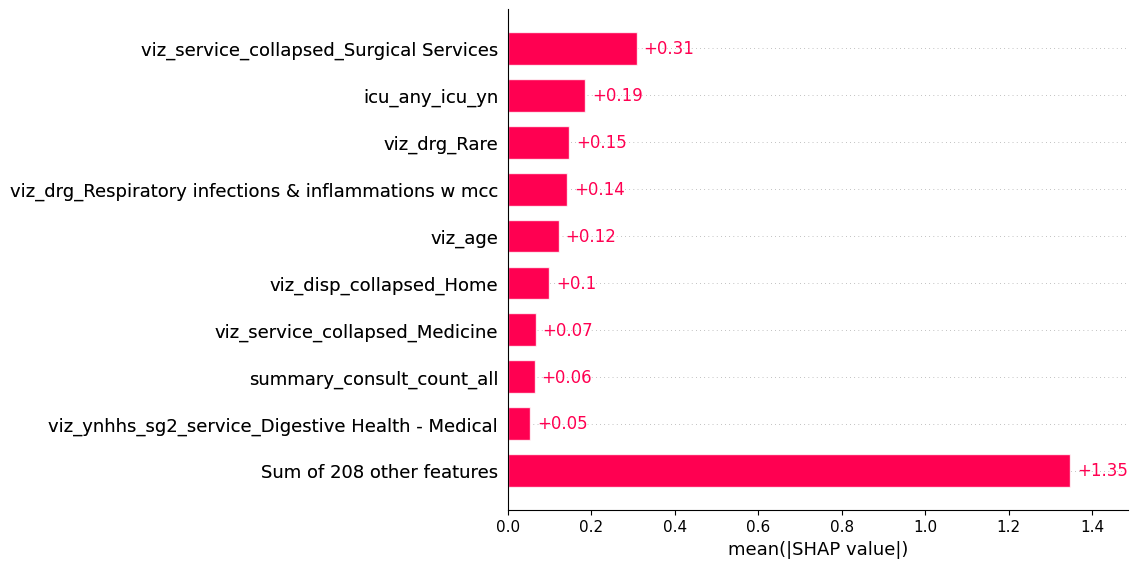

In [67]:
shap.plots.bar(shap_values)

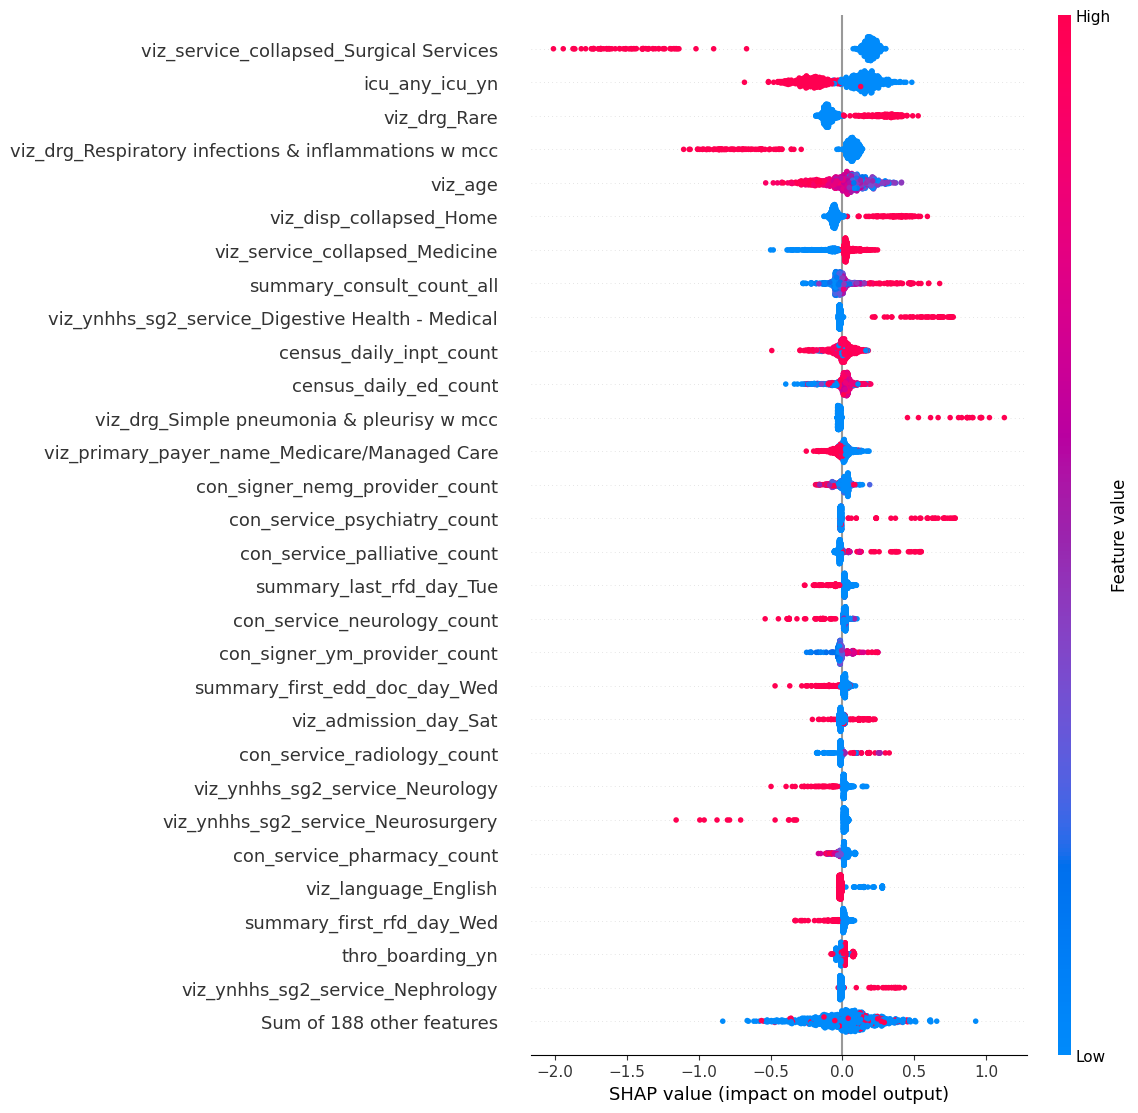

In [68]:
shap.plots.beeswarm(shap_values, max_display=30)